# Pressure

***Pressure***: distance (in metres) beyond a pre-defined threshold: 300 m.

To do this, we need:
- `vector` layer of accessible greenspace
- `raster` reference layer for resolution and crs

**Important:** Running this code assumes a resolution of **10 m** 

#### Import libraries

In [11]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import time
from rasterio import features
from rasterio.plot import show
from rasterio import plot
from scipy import ndimage

#### Import data

In [13]:
%%time
# Import vector layer of accessible green space and a reference raster dataset
OGS = gpd.read_file("P:/NERC_07901_DEFRAG 2021/GIS/DO/Data/All/GSpace/GS_3km_from_build_sites.gpkg")
Ref_Ras = rasterio.open("P:/NERC_07901_DEFRAG 2021/GIS/DO/Data/All/Raster/reference_raster_gspaces_3km_from_built_sites.tif")

CPU times: total: 125 ms
Wall time: 1.06 s


#### Rasterise vector data

In [15]:
%%time
# Get list of geometries from vector layer
geom = [geom for geom in OGS.geometry]

# Rasterize the OGS layer and fill any non-OGS cells with 0
OGS_Rast = features.rasterize(geom, out_shape=Ref_Ras.shape, transform=Ref_Ras.transform, fill=0)

CPU times: total: 31.2 ms
Wall time: 115 ms


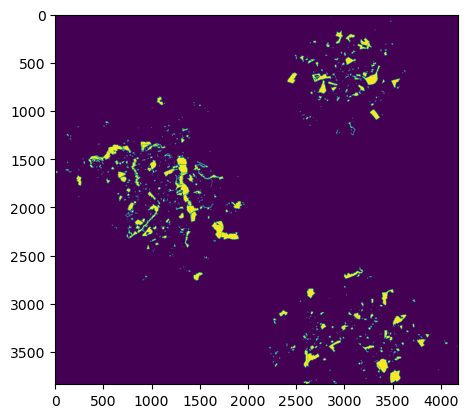

In [16]:
# Visualise the data

# This data is a binary layer
show(OGS_Rast);

#### Distance to Green Space

In [18]:
%%time
# Calculate the distance from non-park cells to park cells

# This algorithm calculates distance from non-zeros to zeros - have to use `np.logical_not` to inverse the binary layer
dist_to_OGS = ndimage.distance_transform_edt(np.logical_not(OGS_Rast), return_indices=False)

# Want the distance in metres - multiply by resolution of cells (10 m)
dist_to_OGS = dist_to_OGS*10

CPU times: total: 969 ms
Wall time: 1.19 s


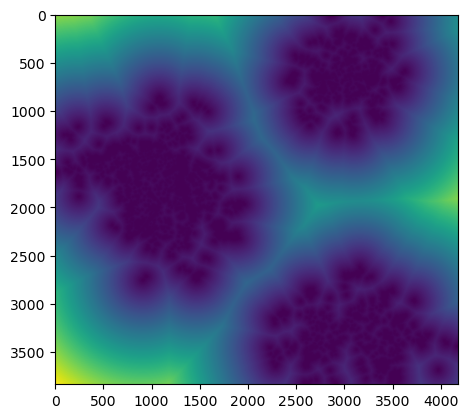

In [19]:
# Visualise the data

# This data is a binary layer
show(dist_to_OGS);

#### Reclassify to show distance beyond 300m

In [21]:
%%time
# reclassify all cells which are less than or equal to 300 to 0, and everything else x-300

dist_to_OGS_reclassified = np.where(dist_to_OGS <= 300, 0, dist_to_OGS-300)

CPU times: total: 15.6 ms
Wall time: 87 ms


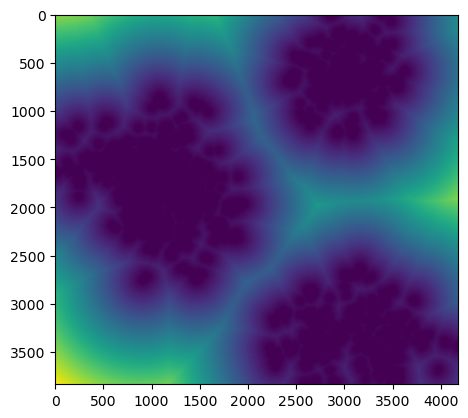

<Axes: >

In [22]:
show(dist_to_OGS_reclassified)

#### Save Output

In [24]:
# Save this distance to greenspace as new raster file as it is currently a numpy array (has no refernce to coordinates).
# We will want to save the file and assign it coordinates and a crs. Easiest way to do this is to use a reference raster layer (e.g., Pop)

# Copy the profile of Pop layer (e.g. CRS, extent, etc.)
profile_ref = Ref_Ras.profile

# Write the file
with rasterio.open("pressure.tif", 'w', **profile_ref) as dst:
     dst.write(dist_to_OGS_reclassified, 1)

# End

---

### Appendix

#### Example of how to change colour scheme and add colourbar

In [28]:
# # Add figure and axes
# fig, ax = plt.subplots(1)

# # Plot the raster
# im = plt.imshow(dist_to_OGS_reclassified, cmap='viridis', vmin=0, vmax=10000)

# # Add a colorbar
# cbar = plt.colorbar(im)

More info on colorbars for raster data - https://github.com/GlacioHack/GeoUtils/issues/93 